In [12]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/Users/vatsal/Desktop/consolidated_trace_data_final2.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\
Sample of the data:")
print(df.head())

print("\
HTTP Status Code Distribution:")
print(df['HTTP Status Code'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186692 entries, 0 to 186691
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Trace-id          186692 non-null  object 
 1   HTTP Status Code  186531 non-null  float64
 2   Path              186692 non-null  object 
 3   User Agent        179243 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.7+ MB
None
Sample of the data:
                           Trace-id  HTTP Status Code  \
0  00000e83229182560bc00dc08d8d0895             200.0   
1  0000ca9c0504724ec0352caf2d927e26             204.0   
2  0000d58f79c6040f625be46853e6143f             200.0   
3  0001693fd167addef160ab0dddfb31d8             200.0   
4  0001c4d4a65e06934a9e38f0f71b6496             204.0   

                                                Path  \
0  /api/v1/nodes/08dd0fba-4f8b-4103-8a95-aed37312...   
1  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.K...   


In [13]:
# Feature Engineering
df['is_successful'] = df['HTTP Status Code'].apply(lambda x: 1 if x == 200 else 0)

# Create suspicious path indicators (common attack patterns)
suspicious_patterns = ['admin', 'login', 'wp-', '.php', '.asp', 'password', 'config', '.git', 'backup', 
                      'test', 'debug', 'dev', 'sql', 'shell', 'script']

df['suspicious_path'] = df['Path'].fillna('').str.lower().apply(
    lambda x: any(pattern in x.lower() for pattern in suspicious_patterns)
)

# Analyze User Agents
df['has_user_agent'] = df['User Agent'].notna()
df['user_agent_length'] = df['User Agent'].fillna('').str.len()

# Calculate request frequency by IP (using trace-id as proxy)
trace_freq = df['Trace-id'].value_counts()
df['request_frequency'] = df['Trace-id'].map(trace_freq)

# Display summary of potentially malicious requests
print("Summary of Potential Security Concerns:")
print("\
Successful requests (Status 200) with suspicious paths:")
print(df[(df['is_successful'] == 1) & (df['suspicious_path'])].shape[0])

print("\
Requests without User Agents:")
print(df[~df['has_user_agent']].shape[0])

print("\
Top 10 most frequent requesters (by Trace-id):")
print(trace_freq.head(10))

# Create a risk score (simple version)
df['risk_score'] = (
    (df['is_successful'] * 3) +  # Successful requests weight
    (df['suspicious_path'] * 2) +  # Suspicious path weight
    (~df['has_user_agent'] * 1) +  # Missing user agent weight
    (np.where(df['request_frequency'] > df['request_frequency'].median(), 1, 0))  # High frequency weight
)

print("\
Distribution of risk scores:")
print(df['risk_score'].value_counts().sort_index())

Summary of Potential Security Concerns:
Successful requests (Status 200) with suspicious paths:
12
Requests without User Agents:
7449
Top 10 most frequent requesters (by Trace-id):
Trace-id
ff631856c9d15dfb2dd945541ae80a1a    3
ca3abffcdeb0a40066ae6dfc75cfad2b    3
3267573129827b1b062f8f4c82e38c0d    3
3440c3ea13775f299580b87b26431fc9    3
5b438147c02df248edbb1bcb778d507c    3
63a6b4b21713fd311115d3548ee74f7d    3
7d04ed0ff2aa99d57c5382dc6e0b5d5d    3
ab6d2db848ede787e5e08bb4835e7ee3    3
c1aa6e00e0fb9090cb3f3677e4286199    3
002a552fad2d886153bd8e6f48f1b383    3
Name: count, dtype: int64
Distribution of risk scores:
risk_score
0     50337
1      2887
2       259
3    128592
4      4432
5       185
Name: count, dtype: int64


In [14]:
pip install numpy==1.21.6


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import re

# Read the data
df = pd.read_csv('/Users/vatsal/Desktop/consolidated_trace_data_final2.csv')


# Enhanced Feature Engineering
def create_features(df):
    # 1. HTTP Status Code Features
    df['is_successful'] = df['HTTP Status Code'].apply(lambda x: 1 if x == 200 else 0)
    df['is_error'] = df['HTTP Status Code'].apply(lambda x: 1 if x >= 400 else 0)
    
    # 2. Enhanced Path Features
    suspicious_patterns = [
        'admin', 'login', 'wp-', '.php', '.asp', 'password', 'config', '.git', 
        'backup', 'test', 'debug', 'dev', 'sql', 'shell', 'script', 'eval', 
        'exec', 'system', 'cmd', 'select', 'union', 'insert', 'delete', 'update'
    ]
    
    df['path_length'] = df['Path'].fillna('').str.len()
    df['suspicious_path'] = df['Path'].fillna('').str.lower().apply(
        lambda x: sum(pattern in x.lower() for pattern in suspicious_patterns)
    )
    df['has_special_chars'] = df['Path'].fillna('').apply(
        lambda x: len(re.findall(r'[;|&`\'"]', x))
    )
    
    # 3. User Agent Features
    df['has_user_agent'] = df['User Agent'].notna().astype(int)
    df['user_agent_length'] = df['User Agent'].fillna('').str.len()
    
    # Common bot patterns
    bot_patterns = ['bot', 'crawler', 'spider', 'scan']
    df['is_bot'] = df['User Agent'].fillna('').str.lower().apply(
        lambda x: any(pattern in x.lower() for pattern in bot_patterns)
    ).astype(int)
    
    # 4. Request Patterns
    trace_freq = df['Trace-id'].value_counts()
    df['request_frequency'] = df['Trace-id'].map(trace_freq)
    
    # 5. API Version Analysis
    df['api_version'] = df['Path'].fillna('').apply(
        lambda x: 1 if '/v1/' in x else (2 if '/v2/' in x else 0)
    )
    
    return df

# Create features
df_featured = create_features(df)

# Calculate Risk Score (Enhanced Version)
df_featured['risk_score'] = (
    (df_featured['is_successful'] * 3) +
    (df_featured['suspicious_path'] * 2) +
    (~df_featured['has_user_agent'] * 2) +
    (df_featured['is_bot'] * 1) +
    (df_featured['has_special_chars'] * 2) +
    (np.where(df_featured['request_frequency'] > df_featured['request_frequency'].median(), 1, 0))
)

# Print summary statistics
print("Feature Engineering Summary:")
print("\
Risk Score Distribution:")
print(df_featured['risk_score'].value_counts().sort_index())

print("\
Suspicious Path Counts:")
print(df_featured['suspicious_path'].value_counts().head())

print("\
Bot Detection:")
print(f"Total Identified Bots: {df_featured['is_bot'].sum()}")

print("\
API Version Distribution:")
print(df_featured['api_version'].value_counts())

/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Feature Engineering Summary:
Risk Score Distribution:
risk_score
-4     50334
-3       123
-2      2864
-1    128729
 0        84
 1      4385
 2       157
 4        16
Name: count, dtype: int64
Suspicious Path Counts:
suspicious_path
0    186567
1       111
2        14
Name: count, dtype: int64
Bot Detection:
Total Identified Bots: 2
API Version Distribution:
api_version
1    82517
2    66454
0    37721
Name: count, dtype: int64


Model Performance Report:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37337
           1       1.00      1.00      1.00         2

    accuracy                           1.00     37339
   macro avg       1.00      1.00      1.00     37339
weighted avg       1.00      1.00      1.00     37339



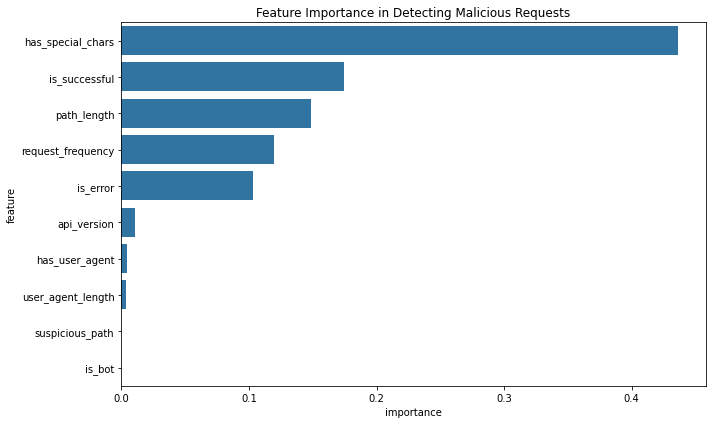

Top 5 Most Important Features:
             feature  importance
4  has_special_chars    0.436202
0      is_successful    0.174674
2        path_length    0.148697
8  request_frequency    0.119222
1           is_error    0.103112


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare features for modeling
features = [
    'is_successful', 'is_error', 'path_length', 'suspicious_path',
    'has_special_chars', 'has_user_agent', 'user_agent_length',
    'is_bot', 'request_frequency', 'api_version'
]

X = df_featured[features]
y = (df_featured['risk_score'] >= 3).astype(int)  # Binary classification for high-risk requests

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print classification report
print("Model Performance Report:")
print("\
Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Detecting Malicious Requests')
plt.tight_layout()
plt.show()

# Print top features
print("\
Top 5 Most Important Features:")
print(feature_importance.head())

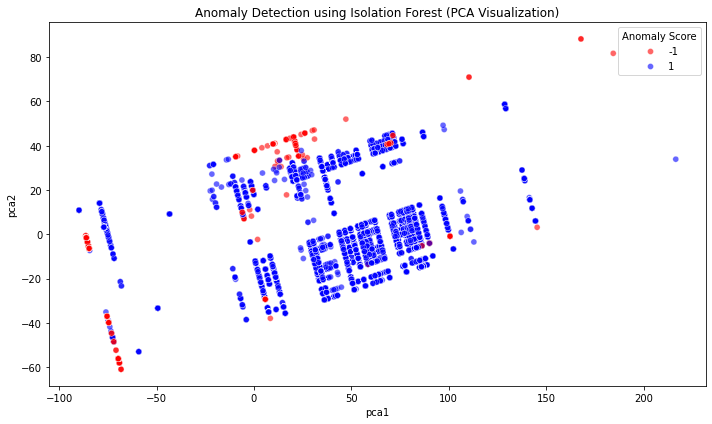

Top 10 Most Suspicious Activities:
                                Trace-id  HTTP Status Code  \
186691  fe453acc90c858ac16deab390423626d             200.0   
186684  af355d38a269beb63e323264bbad63b3             200.0   
186674  198f82c8822d538fe99122f8919d3413             200.0   
186675  30e400c8eb4e05060d79b91c20e23d65             200.0   
186676  414715bdddb59c0e3b97fb5c40430b90             200.0   
186679  57cd049e20babdc27e326082df10ebdc             200.0   
186680  613065ef6e08b410e63f177112f8c940             200.0   
186681  6686a5df1d74e45fb520f4844678d76e             200.0   
186682  953153e9251702fa57ef9f6b52503735             200.0   
186683  9f737667eb36a417cdfef24ab505d716             200.0   

                                                     Path User Agent  \
186691  /api/v2/projects/external-id/OFCAS;ce5480fb-d8...        NaN   
186684  /api/v2/projects/external-id/OFCAS;37171d69-4a...        NaN   
186674  /api/v2/projects/external-id/OFCAS;6e34ec52-f4...        N

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Prepare data for anomaly detection
anomaly_features = [
    'path_length', 'suspicious_path', 'has_special_chars',
    'user_agent_length', 'request_frequency', 'api_version'
]
X_anomaly = df_featured[anomaly_features]

# Fit Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_featured['anomaly_score'] = iso_forest.fit_predict(X_anomaly)

# Separate anomalies
anomalies = df_featured[df_featured['anomaly_score'] == -1]

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_anomaly)
df_featured['pca1'] = X_pca[:, 0]
df_featured['pca2'] = X_pca[:, 1]

# Plot anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca1', y='pca2', hue='anomaly_score', data=df_featured,
    palette={1: 'blue', -1: 'red'}, alpha=0.6
)
plt.title('Anomaly Detection using Isolation Forest (PCA Visualization)')
plt.legend(title='Anomaly Score', loc='upper right')
plt.tight_layout()
plt.show()

# Generate detailed report for top anomalies
top_anomalies = anomalies.sort_values('risk_score', ascending=False).head(10)
print("Top 10 Most Suspicious Activities:")
print(top_anomalies[['Trace-id', 'HTTP Status Code', 'Path', 'User Agent', 'risk_score']])

print(X_pca.shape)

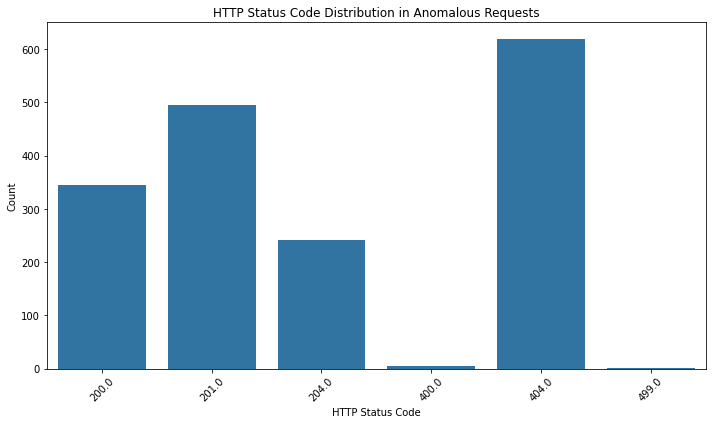

Path Pattern Analysis for Anomalous Requests:
Top 10 Most Common Anomalous Paths:
Path
/                                                                      303
/api/v2/projects/f899745d-f1b4-4439-a6fc-428ce60325f5/project-image    173
 /api/v1/nodes                                                          94
/api/v2/projects/69d98383-7ddf-41ae-9d6f-1699e8b22d4a/project-image     81
/api/v1/nodes/root                                                      75
/api/v2/projects/f84921c0-a6b0-4278-aae7-7f8599b648ae/project-image     67
/api/v2/projects/805dc1f1-3ded-4cd6-b289-27f75b038ec1/project-image     63
/api/v2/projects/ca8610de-23b6-46ec-bf7b-c31ba8d86acc/project-image     62
/api/v2/nodes/root                                                      28
/api/v2/projects/b5ec33f7-71c9-49b9-bfb5-d446bd4a9fff/project-image     18
Name: count, dtype: int64
User Agent Analysis for Anomalous Requests:
Top 10 Most Common User Agents in Anomalous Requests:
User Agent
Mozilla/5.0 (X11; Linux x86_

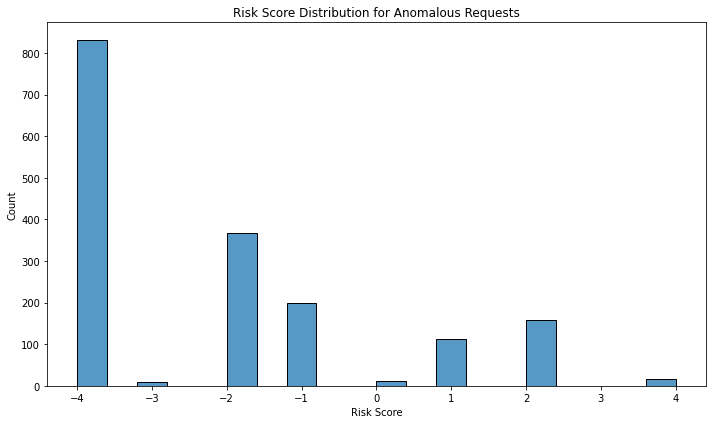

Risk Score Statistics for Anomalous Requests:
count    1706.000000
mean       -2.229191
std         2.110077
min        -4.000000
25%        -4.000000
50%        -2.000000
75%        -1.000000
max         4.000000
Name: risk_score, dtype: float64


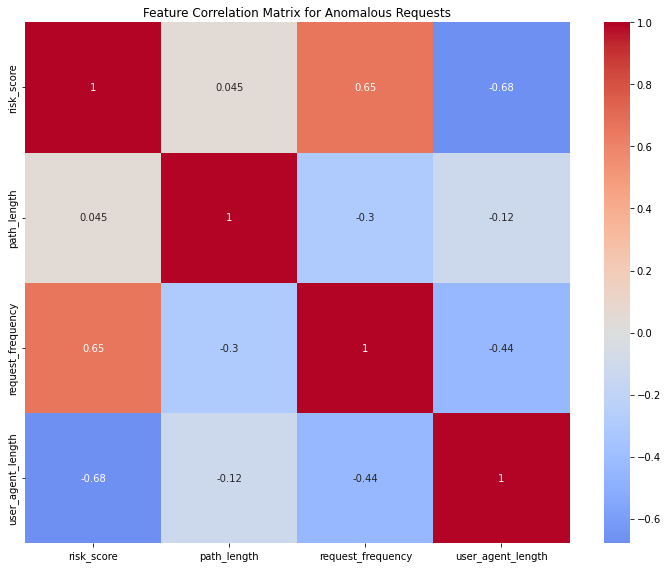

Percentage of Requests Identified as Anomalous: 0.91%


In [6]:
# Let's perform pattern analysis without timestamp data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze patterns in paths for anomalous requests
anomalous_requests = df_featured[df_featured['anomaly_score'] == -1]

# Analyze HTTP Status Code distribution
plt.figure(figsize=(10, 6))
status_counts = anomalous_requests['HTTP Status Code'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('HTTP Status Code Distribution in Anomalous Requests')
plt.xlabel('HTTP Status Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze path patterns
print("\
Path Pattern Analysis for Anomalous Requests:")
path_patterns = anomalous_requests['Path'].value_counts().head(10)
print("\
Top 10 Most Common Anomalous Paths:")
print(path_patterns)

# Analyze User Agent patterns
print("\
User Agent Analysis for Anomalous Requests:")
user_agent_patterns = anomalous_requests['User Agent'].value_counts().head(10)
print("\
Top 10 Most Common User Agents in Anomalous Requests:")
print(user_agent_patterns)

# Risk Score Distribution for Anomalous Requests
plt.figure(figsize=(10, 6))
sns.histplot(data=anomalous_requests, x='risk_score', bins=20)
plt.title('Risk Score Distribution for Anomalous Requests')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate additional statistics
print("\
Risk Score Statistics for Anomalous Requests:")
print(anomalous_requests['risk_score'].describe())

# Analyze correlation between features for anomalous requests
correlation_features = ['risk_score', 'path_length', 'request_frequency', 'user_agent_length']
correlation_matrix = anomalous_requests[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix for Anomalous Requests')
plt.tight_layout()
plt.show()

# Calculate percentage of anomalous requests
anomaly_percentage = (len(anomalous_requests) / len(df_featured)) * 100
print(f"\
Percentage of Requests Identified as Anomalous: {anomaly_percentage:.2f}%")